# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb for a notebook demonstrating how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz -O gkmexplain_positives_impscores.txt.gz
!gunzip gkmexplain_positives_impscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/c8ebc38/modisco/gkmexplain_scores/gkmexplain_dnshuff_impscores.txt.gz -O gkmexplain_dnshuff_impscores.txt.gz
!gunzip gkmexplain_dnshuff_impscores.txt.gz

--2020-04-15 05:46:34--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: 'positives_test.fa.gz'

100%[======================================>] 75,038      --.-K/s   in 0.04s   

2020-04-15 05:46:35 (2.03 MB/s) - 'positives_test.fa.gz' saved [75038/75038]

--2020-04-15 05:46:35--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1000384 (977K) [application/octet-stream]
Saving to: 'gkmexplain_positives_impscores.txt.gz'

100%[=========

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x)) for x,y,z in zip(impscores,onehot_data,hyp_impscores)]))==0

#Read in scores on the dinucleotide-shuffled sequences, taking
# the sum across ACGT at each position, to get an empirical null distribution
# of per-position importance scores
nulldist_perposimp = [
    np.array( [sum([float(z) for z in y.split(",")]) for
                y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_dnshuff_impscores.txt")]

Num onehot sequences: 960


NOTE: in the original GkmExplain paper, a normalization of the importance scores and hypothetical importance scores was proposed, as this was empirically observed to improve the signal-to-noise ratio. For simplicity, we are not applying that normalization here. For details on that normalization, see the Nanog TF-MoDISco notebook in the GkmExplain repo: https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb

Sanity check the scores by plotting

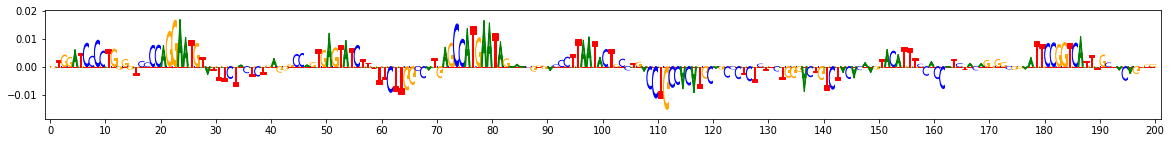

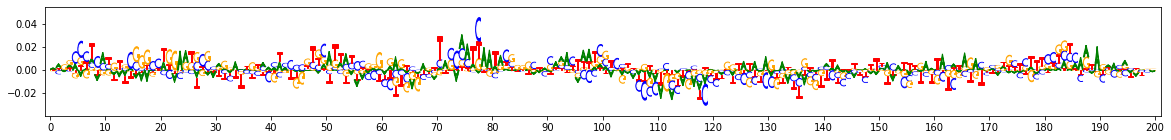

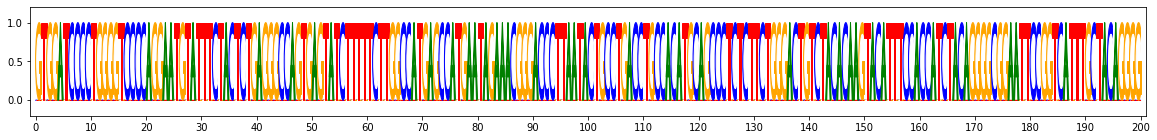

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- The code below uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

MEMORY 0.315731968
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


Thresholds from null dist were -0.32632443699999997  and  0.26635030000000004
Final raw thresholds are -0.32632443699999997  and  0.26635030000000004
Final transformed thresholds are -0.9486284722222222  and  0.9078125


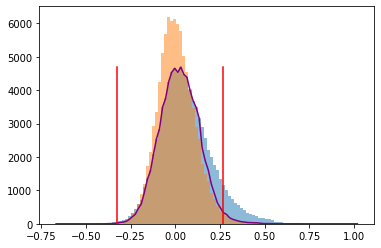

Got 974 coords
After resolving overlaps, got 974 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9077125
MEMORY 0.326275072
974 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [936]
Idx to activities:  {0: '1'}
MEMORY 0.326283264
On metacluster 0
Metacluster size 936
Relevant tasks:  ('task0',)
Relevant signs:  (1,)

TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod anr -nmotifs 10 -minw 6 -maxw 50 -oc meme_out/metacluster0
Duration of MEME: 666.0032589435577 seconds
Skipping motif ARAGCCATYAR as e-value 4.0 does not meet threshold of 0.05
Skipping motif MCTGGGGWGATTAG as e-value 140.0 does not meet threshold of 0.05
Skipping motif SRGGSWGCHSATTVMARGCCYTYTDTSMT as e-value 840.0 does not meet threshold of 0.05
Of 936 seqlets, cluster assignments are: Counter({0: 273, 1: 186, 2: 159, 3: 106, 5: 97, 6: 56, 4: 46, -1: 13})
Aggregating for c

Using TensorFlow backend.


Finished embedding computation in 6.19 s
Starting affinity matrix computations
Normalization computed in 0.09 s
Cosine similarity mat computed in 0.23 s
Normalization computed in 0.1 s
Cosine similarity mat computed in 0.15 s
Finished affinity matrix computations in 0.4 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.62451712
Computed nearest neighbors in 0.55 s
MEMORY 0.635191296
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.635191296
Launching nearest neighbors affmat calculation job
MEMORY 0.650715136
Parallel runs completed
MEMORY 0.5530624
Job completed in: 26.8 s
MEMORY 0.553066496
Launching nearest neighbors affmat calculation job
MEMORY 0.551313408
Parallel runs completed
MEMORY 0.55324672
Job completed in: 25.11 s
MEMORY 0.560259072
(Round 1) Computed affinity matrix on nearest neighbors in 52.2 s
MEMORY 0.560009216
Filtered down to 883 of 936
(Round 1) Retained 883 rows out of 936 after filtering
MEMORY 0.560185344
(Round 1) Computing den

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6976370038305881


  8%|▊         | 4/50 [00:00<00:06,  7.18it/s]

Quality: 0.697638337830391


 54%|█████▍    | 27/50 [00:03<00:03,  6.64it/s]

Quality: 0.6977089157450169


100%|██████████| 50/50 [00:07<00:00,  6.73it/s]

Got 10 clusters after round 1
Counts:
{1: 187, 0: 215, 4: 94, 2: 161, 6: 31, 3: 110, 7: 23, 8: 4, 5: 54, 9: 4}
MEMORY 0.524161024
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.524161024
Aggregating for cluster 0 with 215 seqlets
MEMORY 0.524161024


Trimmed 10 out of 215
Skipped 20 seqlets
Aggregating for cluster 1 with 187 seqlets
MEMORY 0.524161024
Trimmed 6 out of 187
Skipped 30 seqlets
Aggregating for cluster 2 with 161 seqlets
MEMORY 0.524161024
Trimmed 6 out of 161
Skipped 26 seqlets
Aggregating for cluster 3 with 110 seqlets
MEMORY 0.524161024
Trimmed 7 out of 110
Skipped 14 seqlets
Aggregating for cluster 4 with 94 seqlets
MEMORY 0.524161024
Trimmed 1 out of 94
Skipped 16 seqlets
Aggregating for cluster 5 with 54 seqlets
MEMORY 0.524161024
Trimmed 1 out of 54
Skipped 12 seqlets
Aggregating for cluster 6 with 31 seqlets
MEMORY 0.524161024
Trimmed 1 out of 31
Skipped 4 seqlets
Aggregating for cluster 7 with 23 seqlets
MEMORY 0.524161024
Trimmed 6 out of 23
Aggregating for cluster 8 with 4 seqlets
MEMORY 0.524161024
Trimmed 0 out of 4
Skipped 1 seqlets
Aggregating for cluster 9 with 4 seqlets
MEMORY 0.524161024
Trimmed 0 out of 4
Of 722 seqlets, cluster assignments are: Counter({0: 216, 1: 150, 2: 125, 3: 87, 5: 72, 6: 40, 4:

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6146308583685174


  2%|▏         | 1/50 [00:00<00:11,  4.15it/s]

Quality: 0.6151057738813912


  4%|▍         | 2/50 [00:00<00:11,  4.17it/s]

Quality: 0.6155312580371616


  8%|▊         | 4/50 [00:01<00:11,  3.91it/s]

Quality: 0.6160299708867985


 10%|█         | 5/50 [00:01<00:10,  4.15it/s]

Quality: 0.6169325261356209


 20%|██        | 10/50 [00:01<00:05,  6.71it/s]

Quality: 0.6194579685719535


 38%|███▊      | 19/50 [00:03<00:05,  5.28it/s]

Quality: 0.6196846872040842


100%|██████████| 50/50 [00:08<00:00,  5.99it/s]

Got 9 clusters after round 2
Counts:
{4: 97, 0: 140, 2: 101, 8: 19, 1: 138, 6: 36, 3: 98, 5: 60, 7: 33}
MEMORY 0.565669888
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.565669888
Aggregating for cluster 0 with 140 seqlets
MEMORY 0.565669888


Trimmed 7 out of 140
Aggregating for cluster 1 with 138 seqlets
MEMORY 0.565669888
Trimmed 21 out of 138
Aggregating for cluster 2 with 101 seqlets
MEMORY 0.565669888
Trimmed 21 out of 101
Aggregating for cluster 3 with 98 seqlets
MEMORY 0.565669888
Trimmed 10 out of 98
Aggregating for cluster 4 with 97 seqlets
MEMORY 0.565669888
Trimmed 26 out of 97
Skipped 2 seqlets
Aggregating for cluster 5 with 60 seqlets
MEMORY 0.565669888
Trimmed 16 out of 60
Aggregating for cluster 6 with 36 seqlets
MEMORY 0.565669888
Trimmed 1 out of 36
Skipped 1 seqlets
Aggregating for cluster 7 with 33 seqlets
MEMORY 0.565669888
Trimmed 2 out of 33
Aggregating for cluster 8 with 19 seqlets
MEMORY 0.565669888
Trimmed 0 out of 19
Skipped 2 seqlets
Got 9 clusters
Splitting into subclusters...
MEMORY 0.565604352
Inspecting for spurious merging
Wrote graph to binary file in 0.038030147552490234 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00497217
After 3 runs, maximum 

In [6]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        meme_command="meme", base_outdir="meme_out",            
                        num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                    
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    #kmer_len, num_gaps and num_mismatches are used to
                    # derive kmer embeddings for coarse-grained affinity
                    # matrix calculation. kmer_len=6, num_gaps=1
                    # and num_mismatches=0 means
                    # that kmer embeddings using 6-mers with 1 gap will be
                    # used.
                    kmer_len=6, num_gaps=1,
                    num_mismatches=0,
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [7]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


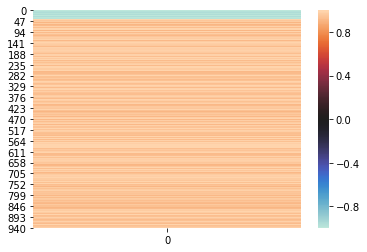

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 179
Hypothetical scores:


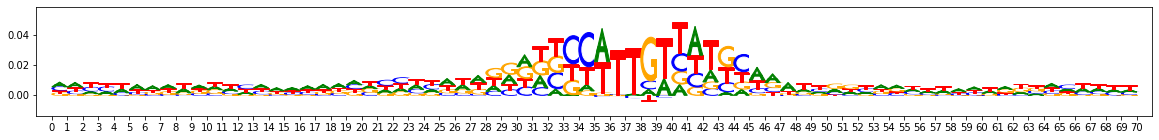

Actual importance scores:


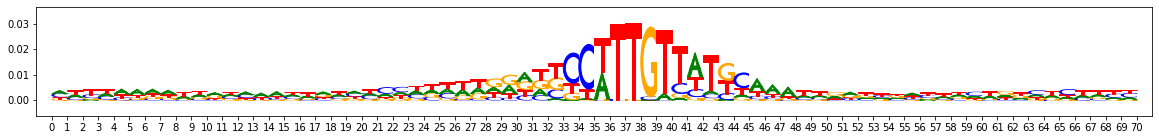

onehot, fwd and rev:


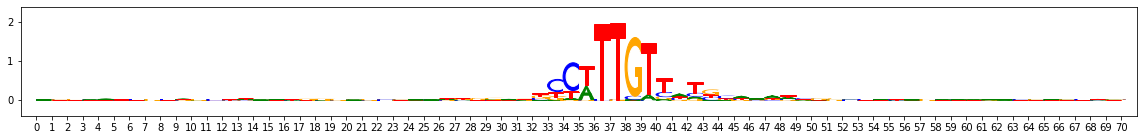

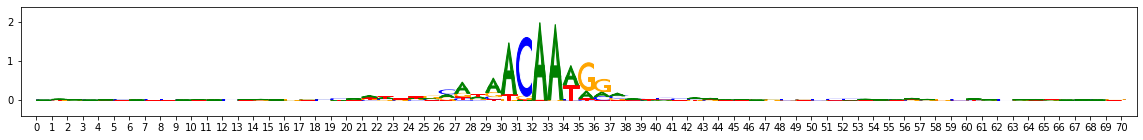

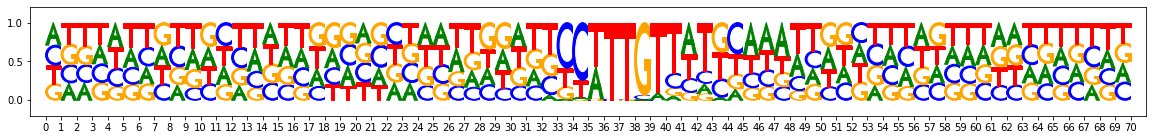

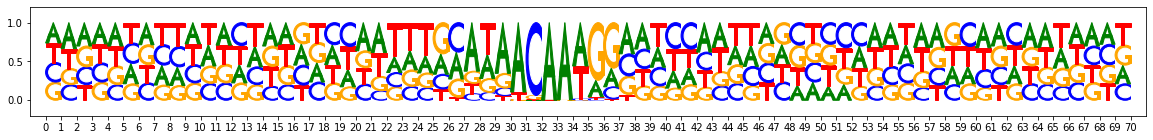

metacluster_0 pattern_1
total seqlets: 189
Hypothetical scores:


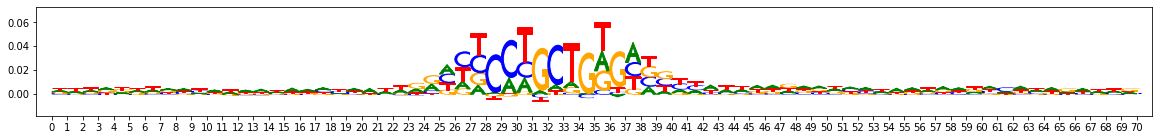

Actual importance scores:


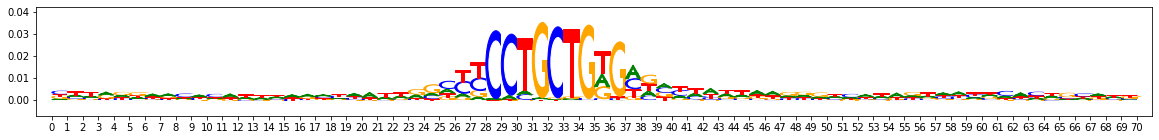

onehot, fwd and rev:


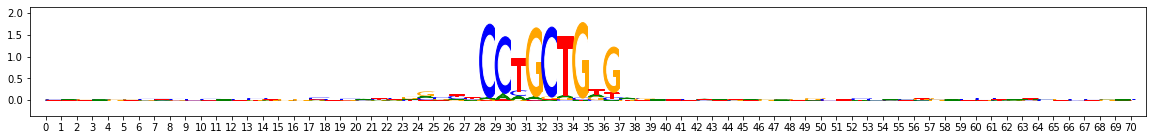

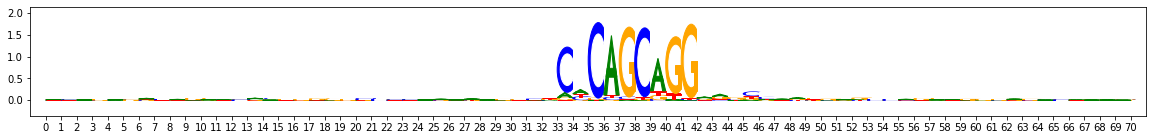

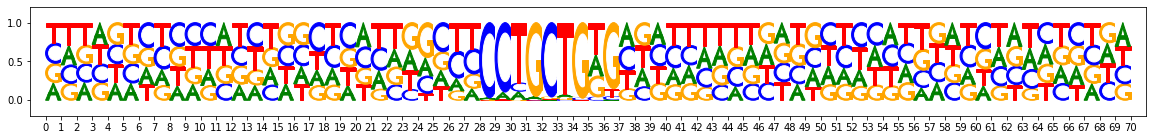

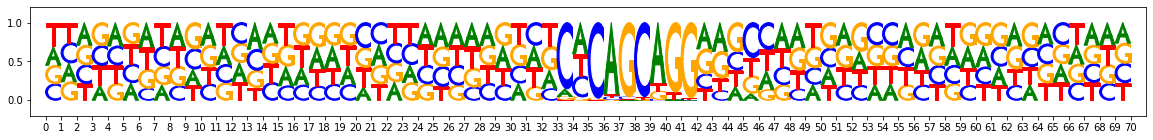

metacluster_0 pattern_2
total seqlets: 108
Hypothetical scores:


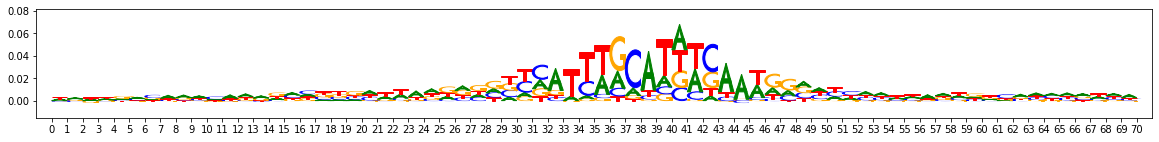

Actual importance scores:


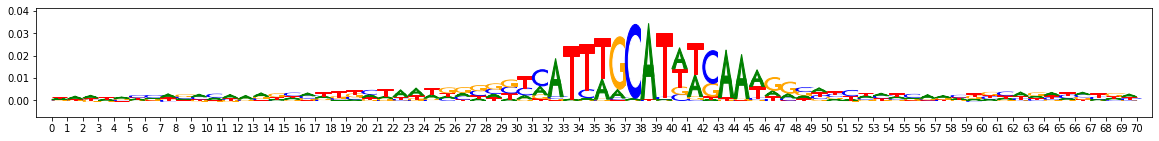

onehot, fwd and rev:


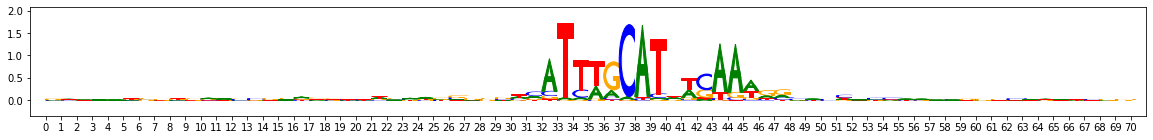

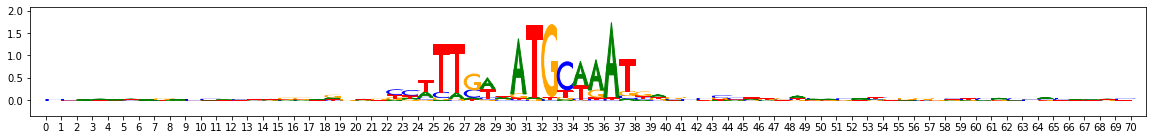

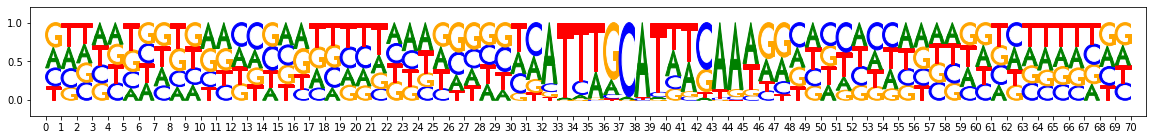

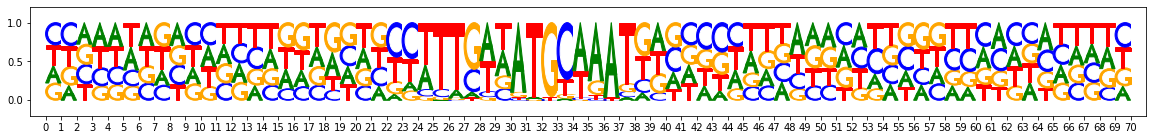

metacluster_0 pattern_3
total seqlets: 54
Hypothetical scores:


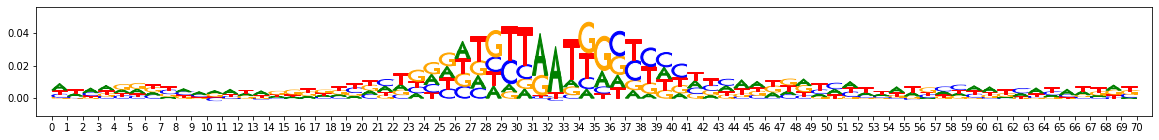

Actual importance scores:


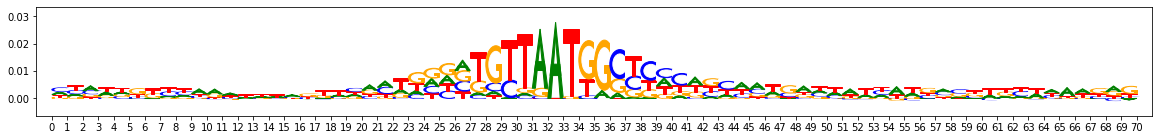

onehot, fwd and rev:


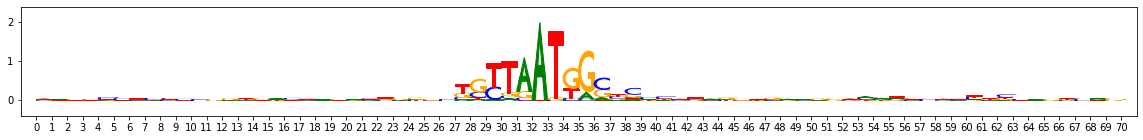

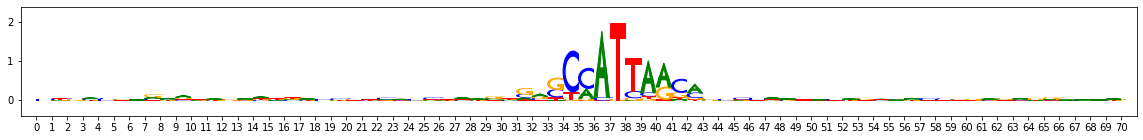

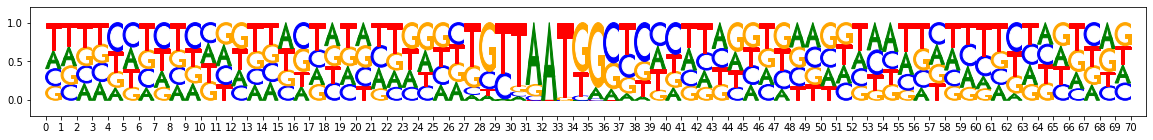

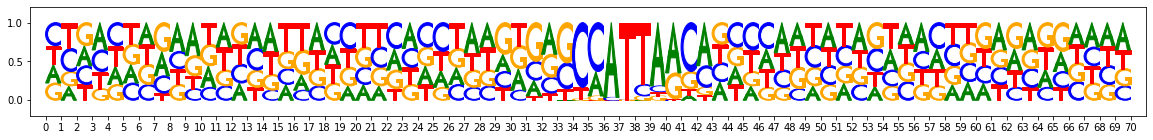

metacluster_0 pattern_4
total seqlets: 36
Hypothetical scores:


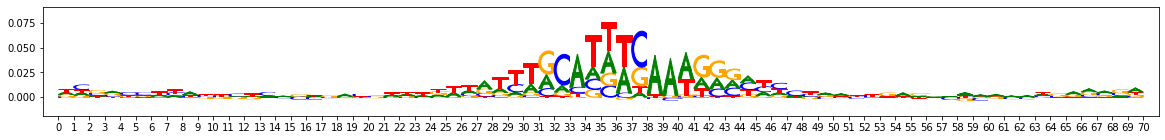

Actual importance scores:


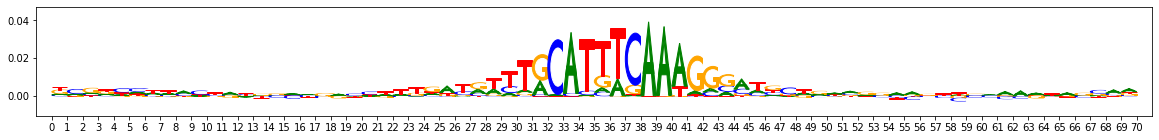

onehot, fwd and rev:


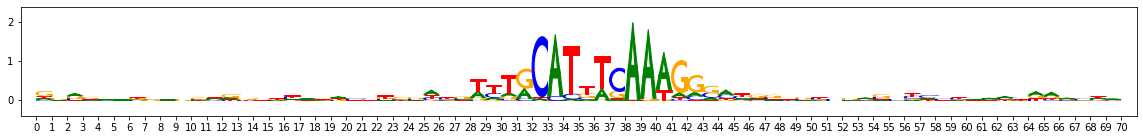

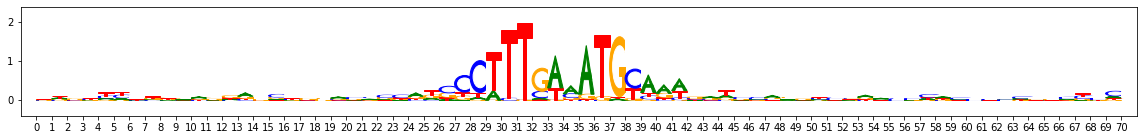

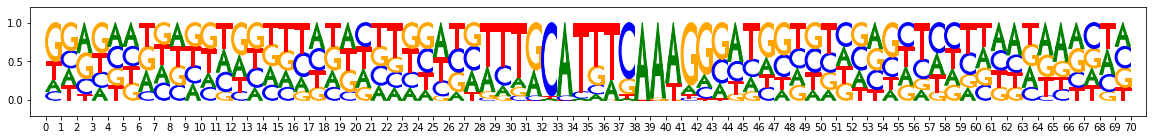

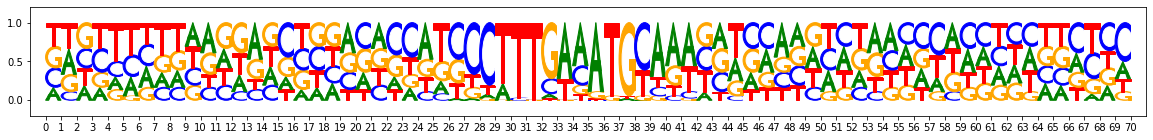

In [11]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
hdf5_results.close()

MEME-DISco motif number 0
num seqlets: 174


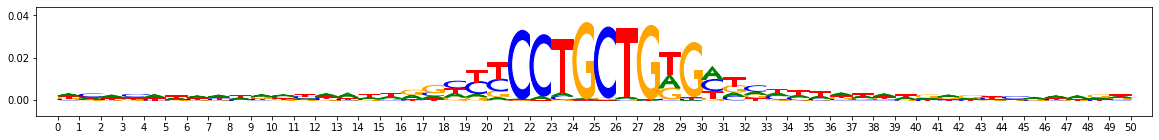

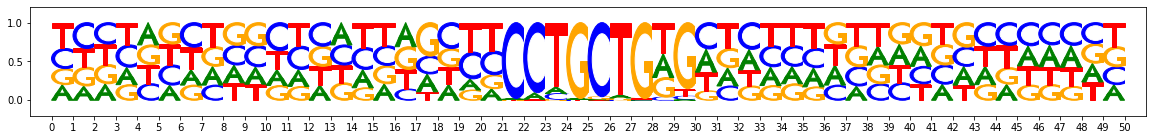

MEME-DISco motif number 1
num seqlets: 144


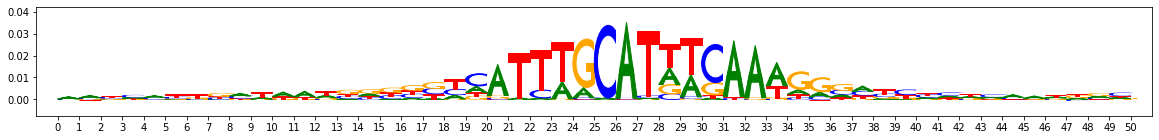

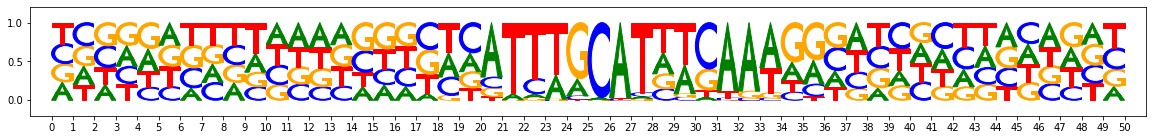

MEME-DISco motif number 2
num seqlets: 108


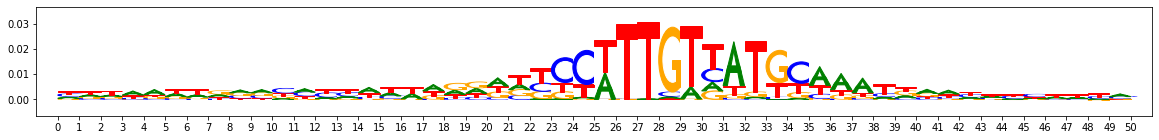

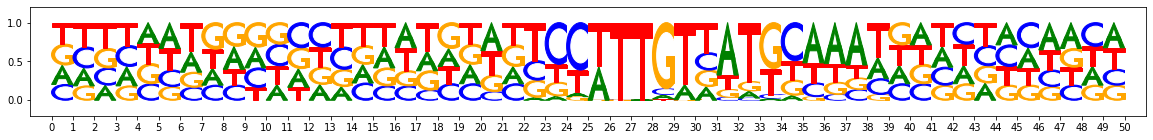

MEME-DISco motif number 3
num seqlets: 77


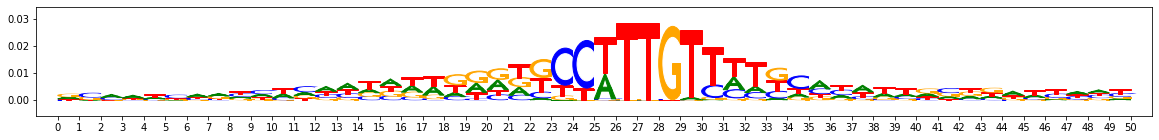

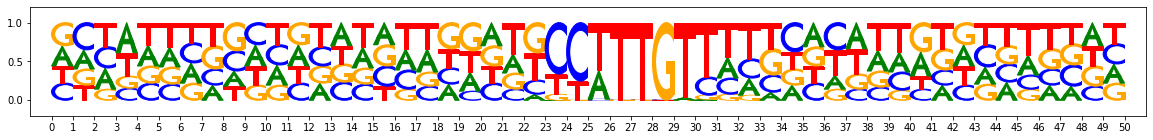

MEME-DISco motif number 4
num seqlets: 40


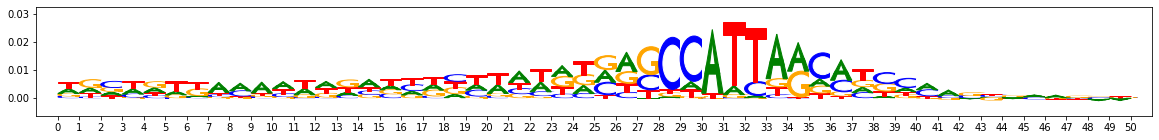

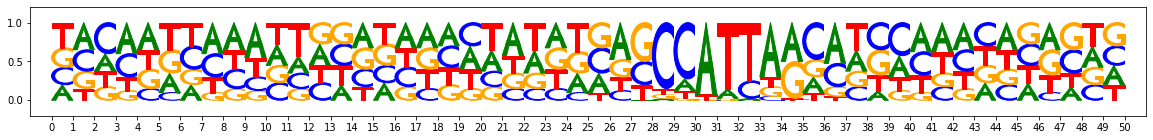

MEME-DISco motif number 5
num seqlets: 34


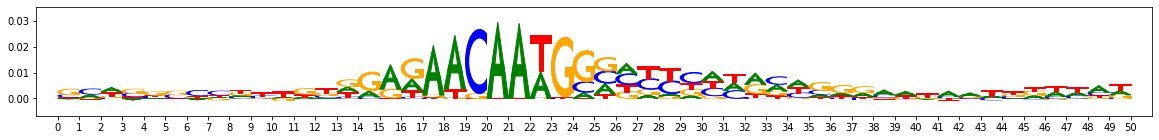

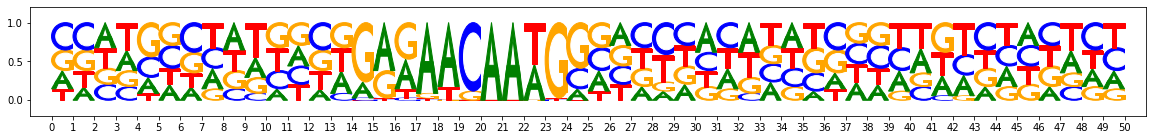

MEME-DISco motif number 6
num seqlets: 20


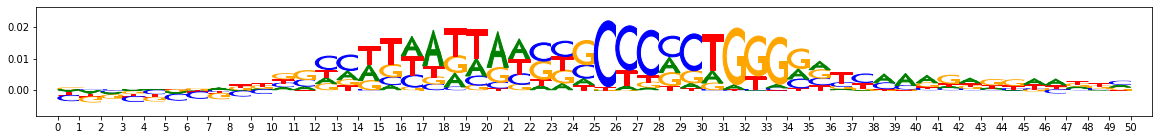

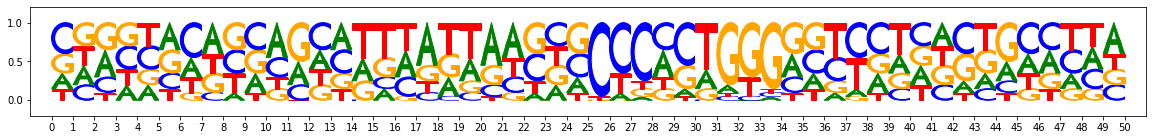

In [12]:
from modisco.visualization import viz_sequence
meme_discovered_motifs = (tfmodisco_results
    .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
    .each_round_initcluster_motifs[1])
for idx,motif in enumerate(meme_discovered_motifs):
    print("MEME-DISco motif number",idx)
    print("num seqlets:",len(motif.seqlets))
    viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
    viz_sequence.plot_weights(motif["sequence"].fwd)

MEME-DISco motif number 0
num seqlets: 222


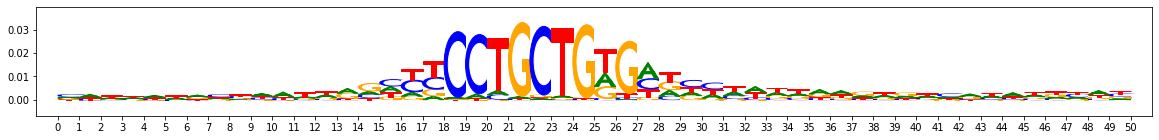

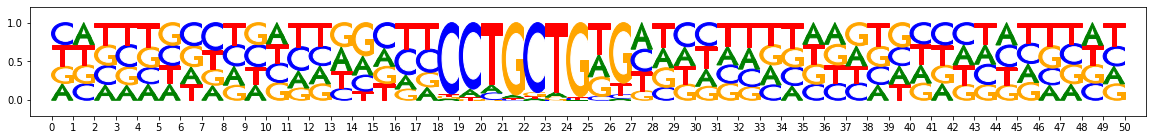

MEME-DISco motif number 1
num seqlets: 151


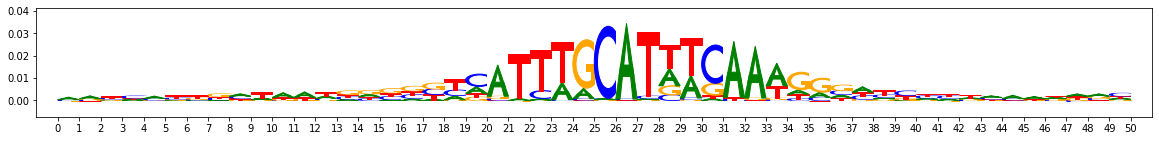

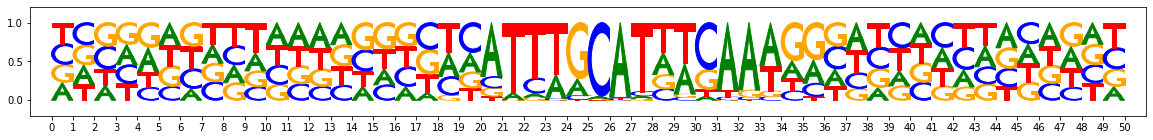

MEME-DISco motif number 2
num seqlets: 126


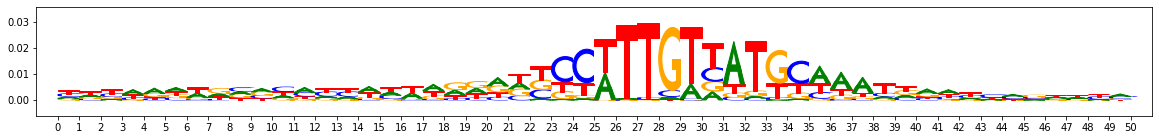

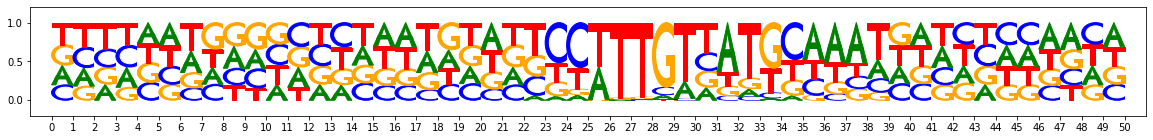

MEME-DISco motif number 3
num seqlets: 86


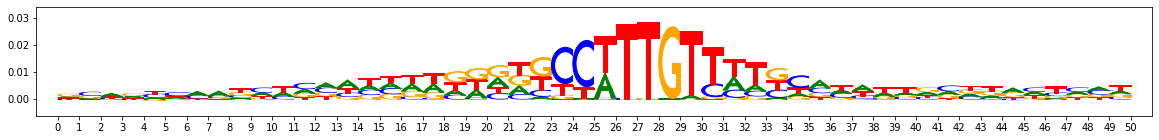

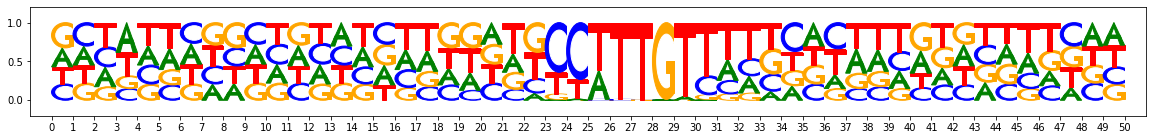

MEME-DISco motif number 4
num seqlets: 80


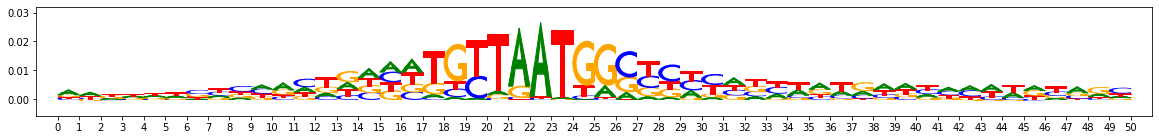

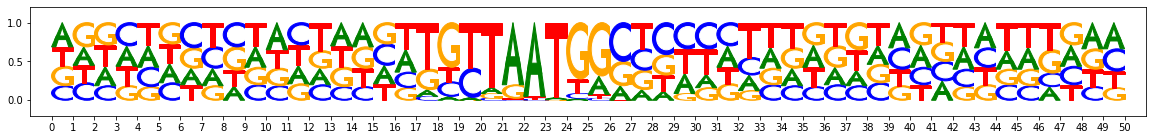

MEME-DISco motif number 5
num seqlets: 43


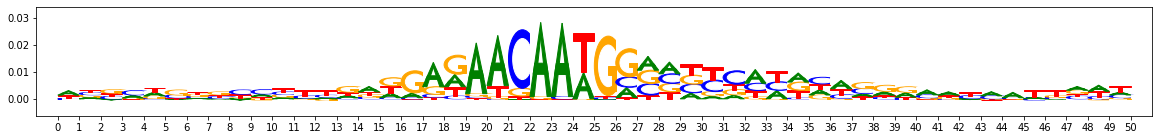

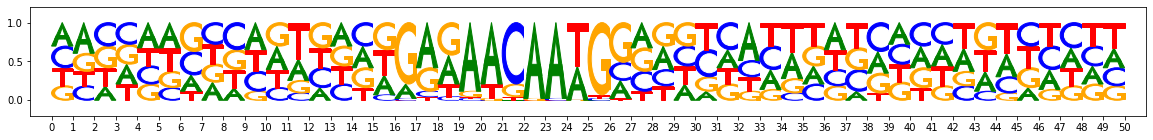

MEME-DISco motif number 6
num seqlets: 39


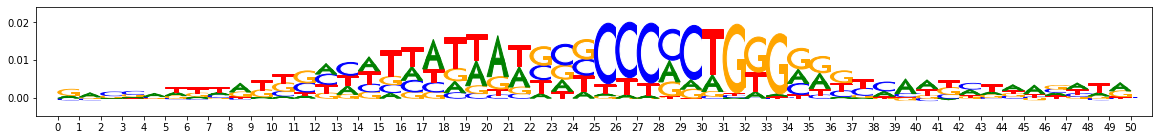

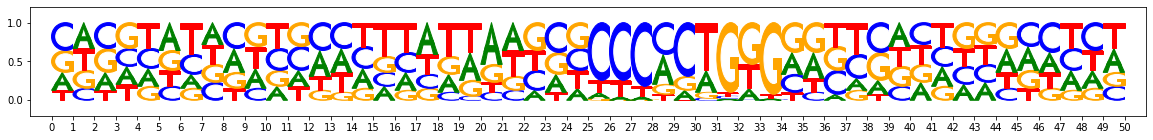

In [13]:
from modisco.visualization import viz_sequence
meme_discovered_motifs = (tfmodisco_results
    .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
    .each_round_initcluster_motifs[0])
for idx,motif in enumerate(meme_discovered_motifs):
    print("MEME-DISco motif number",idx)
    print("num seqlets:",len(motif.seqlets))
    viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
    viz_sequence.plot_weights(motif["sequence"].fwd)